<a href="https://colab.research.google.com/github/hanumantjain/PyTorch/blob/main/Tabular_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install the opendatasets library to download datasets from Kaggle
!pip install opendatasets --quiet
import opendatasets as od

# Download the rice type classification dataset from Kaggle
od.download("https://www.kaggle.com/datasets/mssmartypants/rice-type-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: hanumantjain
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mssmartypants/rice-type-classification


100%|██████████| 888k/888k [00:00<00:00, 652MB/s]

In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Check if GPU is available and set the device accordingly
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
# Load the dataset into a pandas DataFrame
data_df = pd.read_csv("/content/rice-type-classification/riceClassification.csv")
# Display the first few rows of the DataFrame
display(data_df.head())

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [ ]:
# Drop rows with missing values
data_df.dropna(inplace=True)
# Drop the 'id' column as it is not needed for classification
data_df.drop(['id'], axis=1, inplace=True)
# Display the first few rows after dropping
display(data_df.head())

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [ ]:
# Print the shape of the DataFrame (number of rows, number of columns)
print(data_df.shape)

(18185, 11)


In [ ]:
# Print the count of each class in the 'Class' column
print(data_df['Class'].value_counts())

Class
1    9985
0    8200
Name: count, dtype: int64


In [ ]:
# Create a copy of the original DataFrame before normalization
original_df = data_df.copy()

# Normalize each column by dividing by its absolute maximum value
for column in data_df.columns:
  data_df[column] = data_df[column]/data_df[column].abs().max()

# Display the first few rows of the normalized DataFrame
display(data_df.head())

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


In [ ]:
# Separate features (X) and target variable (Y)
# X contains all columns except the last one
X = np.array(data_df.iloc[:, :-1])
# Y contains only the last column ('Class')
Y = np.array(data_df.iloc[:, -1])

In [ ]:
# Split the dataset into training (70%) and testing (30%) sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3)

In [ ]:
# Split the test dataset further into testing (50%) and validation (50%) sets
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size = 0.5)

In [ ]:
# Print the shapes of the training, testing, and validation sets
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(12729, 10)
(2728, 10)
(2728, 10)


In [ ]:
# Define a custom Dataset class for PyTorch
class dataset(Dataset):
  def __init__(self, X, Y):
    # Convert numpy arrays to PyTorch tensors and move to the selected device (CPU or GPU)
    self.X = torch.tensor(X, dtype= torch.float32).to(device)
    self.Y = torch.tensor(Y, dtype= torch.float32).to(device)

  def __len__(self):
    # Return the number of samples in the dataset
    return len(self.X)

  def __getitem__(self, index):
    # Return a sample and its corresponding label at the given index
    return self.X[index], self.Y[index]

In [ ]:
# Create Dataset objects for training, validation, and testing data
training_data = dataset(X_train, Y_train)
validation_data = dataset(X_val, Y_val)
testing_data = dataset(X_test, Y_test)

In [ ]:
# Create DataLoaders for training, validation, and testing datasets
# DataLoader provides an iterator over the dataset, supporting batching and shuffling
train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(testing_data, batch_size=32, shuffle=True)

In [ ]:
# Iterate through the training DataLoader and print one batch of inputs and labels
for x, y in train_dataloader:
  print(x)
  print('======')
  print(y)
  break

tensor([[0.6316, 0.8586, 0.6435, 0.9736, 0.6001, 0.7948, 0.6350, 0.6861, 0.7360,
         0.7570],
        [0.6689, 0.8517, 0.6875, 0.9635, 0.6310, 0.8178, 0.5485, 0.6911, 0.7679,
         0.7028],
        [0.6374, 0.6636, 0.8453, 0.8470, 0.6076, 0.7984, 0.7076, 0.6183, 0.9143,
         0.4454],
        [0.6155, 0.8650, 0.6230, 0.9784, 0.5884, 0.7845, 0.5193, 0.7008, 0.6873,
         0.7878],
        [0.6716, 0.7749, 0.7589, 0.9282, 0.6465, 0.8195, 0.6740, 0.6674, 0.8269,
         0.5793],
        [0.8453, 0.8599, 0.8578, 0.9240, 0.8098, 0.9194, 0.6281, 0.7410, 0.8443,
         0.5687],
        [0.9186, 0.8742, 0.9138, 0.9125, 0.8674, 0.9584, 0.7035, 0.7532, 0.8879,
         0.5428],
        [0.7849, 0.8452, 0.8099, 0.9330, 0.7513, 0.8860, 0.7825, 0.7252, 0.8184,
         0.5921],
        [0.4452, 0.7649, 0.5043, 0.9877, 0.4235, 0.6672, 0.6415, 0.5973, 0.6843,
         0.8605],
        [0.9510, 0.9242, 0.8940, 0.9309, 0.9145, 0.9752, 0.7175, 0.7907, 0.8342,
         0.5865],
        [0

In [ ]:
# Define the number of neurons in the hidden layer
HIDDEN_NEURONS = 10

# Define the neural network model
class MyModel(nn.Module):
  def __init__(self):
    super(MyModel, self).__init__()

    # Input layer: maps from input features to hidden neurons
    self.input_layer = nn.Linear(X.shape[1], HIDDEN_NEURONS)
    # Output layer: maps from hidden neurons to a single output (for binary classification)
    self.linear = nn.Linear(HIDDEN_NEURONS, 1)
    # Sigmoid activation function for the output layer (squashes output between 0 and 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    # Forward pass through the network
    x = self.input_layer(x)
    x = self.linear(x)
    x = self.sigmoid(x)
    return x

# Create an instance of the model and move it to the selected device
model = MyModel().to(device)

In [ ]:
# Print a summary of the model architecture and parameters
summary(model, (X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [ ]:
# Define the loss function (Binary Cross-Entropy for binary classification)
criterion = nn.BCELoss()
# Define the optimizer (Adam optimizer) with a learning rate of 1e-3
optimizer = Adam(model.parameters(), lr=1e-3)

In [ ]:
# Initialize lists to store loss and accuracy for plotting
total_loss_train_plot = []
total_loss_validation_plot = []
total_accuracy_train_plot = []
total_accuracy_validation_plot = []

# Define the number of training epochs
epochs = 10
# Training loop
for epoch in range(epochs):
  # Initialize total loss and accuracy for the current epoch
  total_accuracy_train = 0
  total_loss_train = 0
  total_accuracy_validation = 0
  total_loss_validation = 0

  # Iterate over the training data in batches
  for data in train_dataloader:
    inputs, labels = data

    # Perform forward pass
    prediction = model(inputs).squeeze(1)

    # Calculate batch loss
    batch_loss = criterion(prediction, labels)
    total_loss_train += batch_loss.item()

    # Calculate batch accuracy
    accuracy = ((prediction).round() == labels).sum().item()
    total_accuracy_train += accuracy

    # Perform backward pass and optimization
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  # Evaluate the model on the validation set (no gradient calculation)
  with torch.no_grad():
    for data in validation_dataloader:
      inputs, labels = data

      # Perform forward pass
      prediction = model(inputs).squeeze(1)

      # Calculate batch loss
      batch_loss = criterion(prediction, labels)
      total_loss_validation += batch_loss.item()

      # Calculate batch accuracy
      accuracy = ((prediction).round() == labels).sum().item()
      total_accuracy_validation += accuracy

    # Append epoch loss and accuracy to the lists
    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_loss_validation_plot.append(round(total_loss_validation/1000, 4))

    total_accuracy_train_plot.append(round(total_accuracy_train/training_data.__len__() * 100, 4))
    total_accuracy_validation_plot.append(round(total_accuracy_validation/validation_data.__len__() * 100, 4))

    # Print epoch summary
    print(f'''Epoch no. {epoch+1} Train Loss: {round(total_loss_train/1000, 4)} Train Accuracy: {round(total_accuracy_train/training_data.__len__() * 100, 4)}
              Validation Loss: {round(total_loss_validation/1000, 4)} Validation Accuracy: {round(total_accuracy_validation/validation_data.__len__() * 100, 4)}''')
    print("="*25)

Epoch no. 1 Train Loss: 0.2547 Train Accuracy: 71.891
              Validation Loss: 0.0463 Validation Accuracy: 98.3138
Epoch no. 2 Train Loss: 0.1562 Train Accuracy: 97.3604
              Validation Loss: 0.0228 Validation Accuracy: 98.2405
Epoch no. 3 Train Loss: 0.076 Train Accuracy: 98.0203
              Validation Loss: 0.0121 Validation Accuracy: 98.4604
Epoch no. 4 Train Loss: 0.045 Train Accuracy: 98.2717
              Validation Loss: 0.0081 Validation Accuracy: 98.5337
Epoch no. 5 Train Loss: 0.0325 Train Accuracy: 98.3974
              Validation Loss: 0.0063 Validation Accuracy: 98.6437
Epoch no. 6 Train Loss: 0.0266 Train Accuracy: 98.4916
              Validation Loss: 0.0053 Validation Accuracy: 98.6804
Epoch no. 7 Train Loss: 0.0232 Train Accuracy: 98.5466
              Validation Loss: 0.0048 Validation Accuracy: 98.607
Epoch no. 8 Train Loss: 0.0211 Train Accuracy: 98.5073
              Validation Loss: 0.0043 Validation Accuracy: 98.717
Epoch no. 9 Train Loss: 0.019

In [ ]:
# Evaluate the model on the test set (no gradient calculation)
with torch.no_grad():
  total_loss_test = 0
  total_accuracy_test = 0

  # Iterate over the test data in batches
  for data in test_dataloader:
    inputs, labels = data

    # Perform forward pass
    prediction = model(inputs).squeeze(1)

    # Calculate batch loss
    batch_loss_test = criterion(prediction, labels).item()
    total_loss_test += batch_loss_test

    # Calculate batch accuracy
    accuracy = ((prediction).round() == labels).sum().item()
    total_accuracy_test += accuracy

# Print the final test accuracy
print("Accuracy: ", round(total_accuracy_test/testing_data.__len__() * 100, 4))

Accuracy:  98.7903


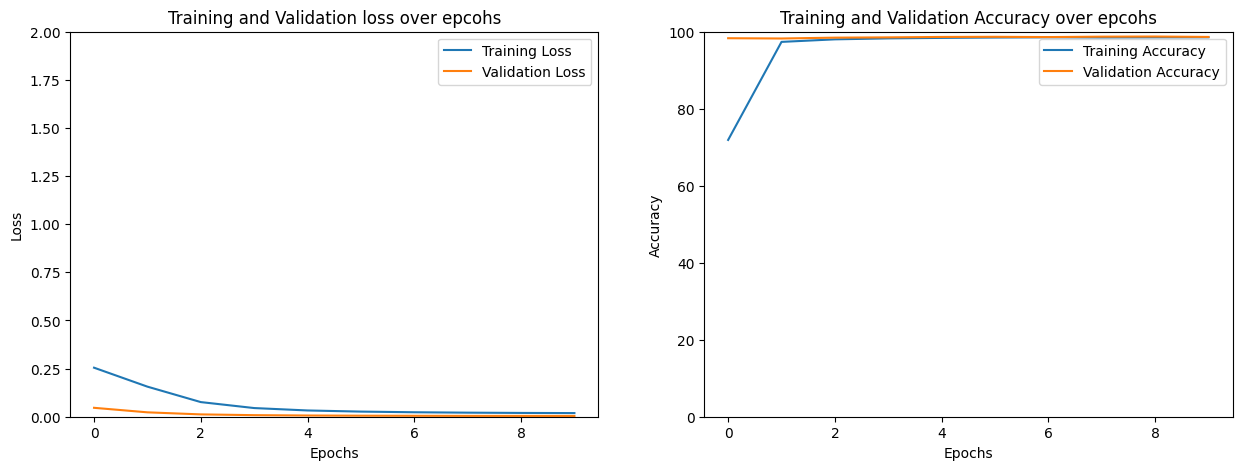

In [ ]:
# Create a figure and subplots for plotting loss and accuracy
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

# Plot training and validation loss
axs[0].plot(total_loss_train_plot, label = 'Training Loss')
axs[0].plot(total_loss_validation_plot, label = 'Validation Loss')
axs[0].set_title('Training and Validation loss over epcohs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim([0,2]) # Set y-axis limits for better visualization
axs[0].legend()

# Plot training and validation accuracy
axs[1].plot(total_accuracy_train_plot, label = 'Training Accuracy')
axs[1].plot(total_accuracy_validation_plot, label = 'Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over epcohs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0,100]) # Set y-axis limits for better visualization
axs[1].legend()

# Display the plots
plt.show()

In [ ]:
# Normalize the input features using the maximum values from the original DataFrame
area = 2353/original_df['Area'].abs().max()
MajorAxisLength =81/original_df['MajorAxisLength'].abs().max()
MinorAxisLength =42/original_df['MinorAxisLength'].abs().max()
Eccentricity =32/original_df['Eccentricity'].abs().max()
ConvexArea =12/original_df['ConvexArea'].abs().max()
EquivDiameter =33/original_df['EquivDiameter'].abs().max()
Extent =98/original_df['Extent'].abs().max()
Perimeter =927/original_df['Perimeter'].abs().max()
Roundness =677/original_df['Roundness'].abs().max()
AspectRation =24/original_df['AspectRation'].abs().max()

# Convert the list of features to a PyTorch Tensor and move it to the device
input_features = torch.tensor([[area, MajorAxisLength, MinorAxisLength, Eccentricity, ConvexArea, EquivDiameter, Extent, Perimeter, Roundness, AspectRation]],
                              dtype=torch.float32).to(device)

# Pass the tensor to the model to get the prediction
prediction = model(input_features)

# Print the prediction tensor
print(prediction)

tensor([[0.]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [ ]:
# Extract the scalar value from the prediction tensor
prediction.item()

0.0